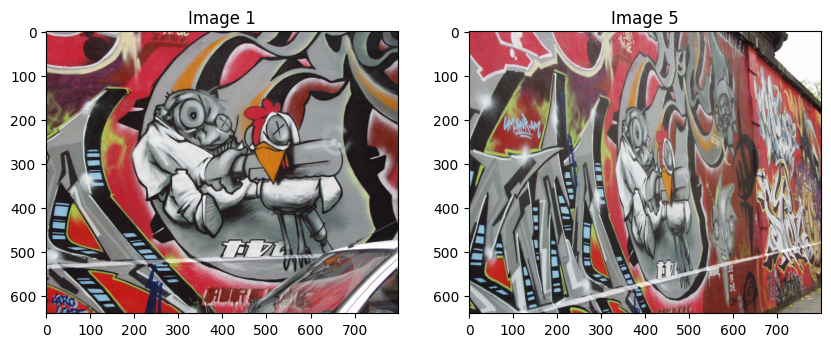

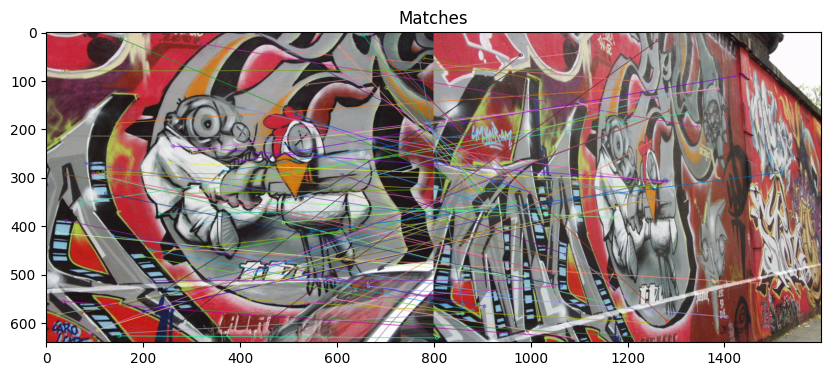

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img1 = cv2.imread('img1.ppm', cv2.IMREAD_ANYCOLOR)
img5 = cv2.imread('img5.ppm', cv2.IMREAD_ANYCOLOR)

# Plot the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Image 1')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Image 5')
plt.imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
plt.show()

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors in both images
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5, None)

# Create a brute-force matcher
bf = cv2.BFMatcher()

# Match descriptors
matches = bf.knnMatch(descriptors1, descriptors5, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches = []
pts1 = []
pts2 = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
        pts1.append(keypoints1[m.queryIdx].pt)
        pts2.append(keypoints5[m.trainIdx].pt)

# Draw the matches
match_img = cv2.drawMatches(img1, keypoints1, img5, keypoints5, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Save the image with matches
cv2.imwrite('matches.jpg', match_img)

# Change the image to RGB color space
#match_img = cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)

# Plot the image with matches
plt.figure(figsize=(10, 10))
plt.title('Matches')
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.show()

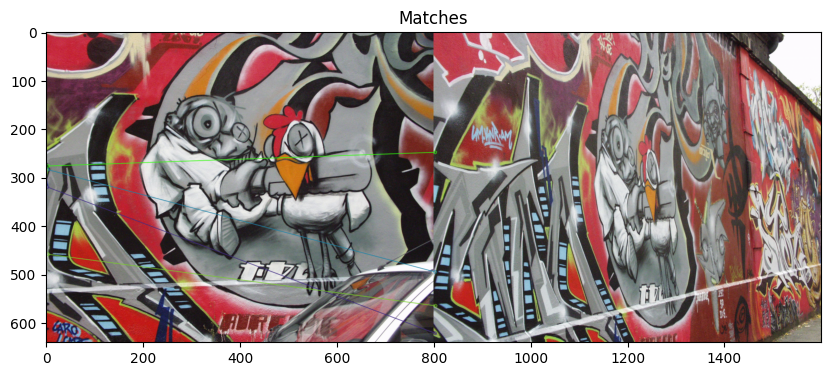

Homography Matrix:
[[ 5.06861887e-01 -2.13628079e+00  6.46453916e+02]
 [ 3.92215607e-01 -1.06241049e+00  2.45778810e+02]
 [ 1.37327366e-03 -4.12524192e-03  1.00000000e+00]]
 
Original Homography Matrix:
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


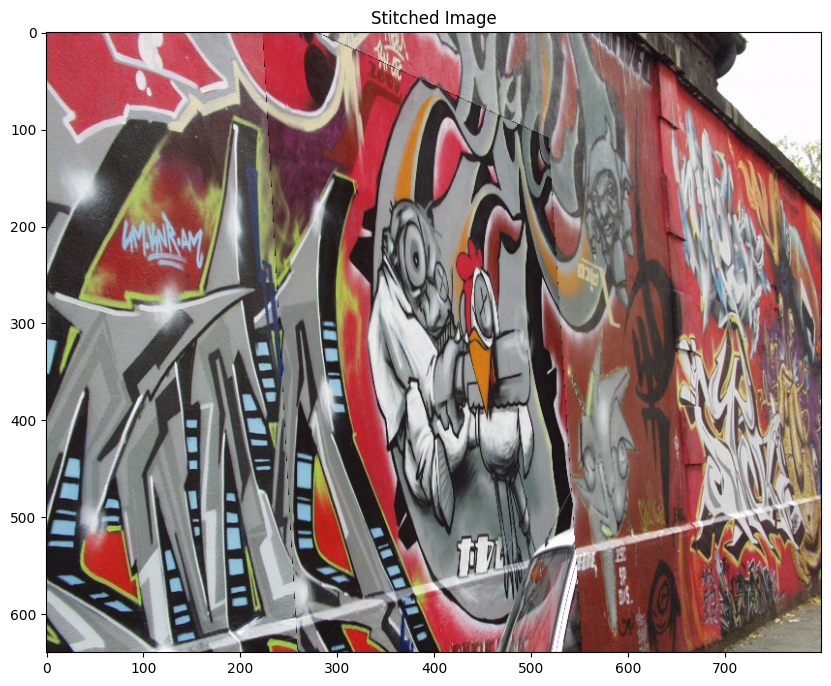

In [52]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def ransac_matching(img1, img2, num_iterations=1000, max_distance=10, min_inliers=100):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors in both images
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img5, None)

    # Create a brute-force matcher
    bf = cv2.BFMatcher()

    best_matches = []  # Store the best matches found by RANSAC
    best_homography = None  # Store the best homography matrix
    best_inliers = []  # Store the inliers of the best model

    for _ in range(num_iterations):
        # Randomly select four matches
        random_matches = random.sample(range(len(keypoints1)), 4)

        # Get the keypoints for the selected matches
        src_pts = np.float32([keypoints1[m].pt for m in random_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m].pt for m in random_matches]).reshape(-1, 1, 2)
        

        # Compute the homography matrix
        homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, max_distance)

        # Transform keypoints from img1 to img2 using the computed homography
        transformed_pts = cv2.perspectiveTransform(src_pts, homography)

        # Calculate the Euclidean distances between transformed and actual keypoints in img2
        distances = np.sqrt(np.sum((dst_pts - transformed_pts) ** 2, axis=2))

        # Count the number of inliers (matches within a certain distance threshold)
        inliers = np.count_nonzero(distances < max_distance)

        # Update if this model has more inliers than the current best
        if inliers > len(best_inliers):
            best_inliers = distances < max_distance
            best_matches = random_matches
            best_homography = homography

        # If we have enough inliers, exit early
        if inliers >= min_inliers:
            break

    # Filter the best matches using inliers
    filtered_matches = [cv2.DMatch(i, i, 0) for i, is_inlier in enumerate(best_inliers) if is_inlier]

    return filtered_matches, best_homography, keypoints1, keypoints2


# Find matching points using custom RANSAC
matches, homography, keypoints1, keypoints2 = ransac_matching(img1, img5)

# Draw the matching points
matched_img = cv2.drawMatches(img1, keypoints1, img5, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show the image with matches
plt.figure(figsize=(10, 10))
plt.title('Matches')
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.show()

print("Homography Matrix:")
print(homography)

print(" ")

# Load homography matrix from file
homography = np.loadtxt(r"E:\UOM\Academic\Semester 5\Image processing and machine vision\EN3160---Image-Processing-and-Machine-Vision\Assignment_02  - Fitting and Alignment\graf\H1to5p")

# Print the original homography matrix
print("Original Homography Matrix:")
print(homography)

# Warp img1 onto img5 using the homography
img1_warped = cv2.warpPerspective(img1, homography, (img5.shape[1], img5.shape[0]))

# Create a binary mask of the warped image
_, img1_mask = cv2.threshold(cv2.cvtColor(img1_warped, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY)

# Invert the mask to get the region where img1 should be placed
img5_mask = cv2.bitwise_not(img1_mask)

# Blend the two images together
result = cv2.bitwise_and(img5, img5, mask=img5_mask)
result = cv2.add(result, img1_warped)

# Display the stitched image
plt.figure(figsize=(10, 10))
plt.title('Stitched Image')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()
